## Challenge 1
Model that **predicts** a gem's worth based on its characteristics. -> Regression
- Wants the why behind every price tag.

Create a Jupyter notebook where you **develop** and **evaluate** your model.

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [48]:
df = pd.read_csv("..\..\datasets\diamonds\diamonds.csv")
df.head()
#df.count() #5000 gems
#df.notnull().all() #no missing values

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


### Dataset Analysis

In [58]:
def review_plot (df):
    print(f"#Gems={df.shape[0]}")
    num_cols = df.shape[1]
    num_rows = math.ceil(num_cols / 2)
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*2))
    axs = axs.ravel()
    for i, c in enumerate(df.columns):
        axs[i].hist(df[c], bins=100)
        axs[i].set_xlabel(c)
        axs[i].set_ylabel('Frequency')
        min_val = df[c].min()
        max_val = df[c].max()
        axs[i].annotate(f'Min: {min_val}', xy=(0.75, 0.85), xycoords='axes fraction')
        axs[i].annotate(f'Max: {max_val}', xy=(0.75, 0.75), xycoords='axes fraction')
    plt.tight_layout()
    plt.show()

#Gems=5000


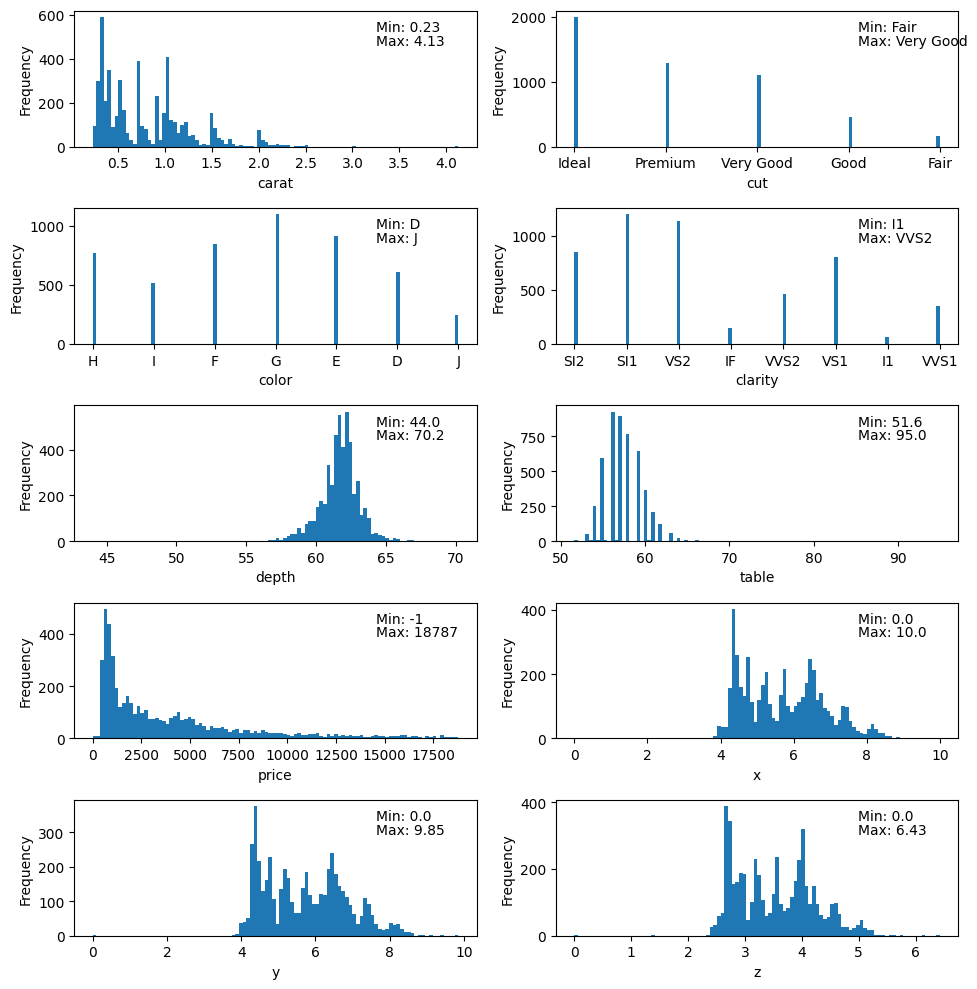

In [59]:
review_plot(df)

### Handling outliers

In [67]:
df_cleaned = df.copy()
df_cleaned.drop(df_cleaned[df_cleaned['price'] <= 0].index,inplace=True)

top = 0.98 # remove top 2% of data
bottom = 0.02 # remove bottom 2% of data
df_cleaned = df_cleaned[(df_cleaned['x'] > df_cleaned['x'].quantile(bottom)) & 
                        (df_cleaned['x'] < df_cleaned['x'].quantile(top)) & 
                        (df_cleaned['y'] > df_cleaned['y'].quantile(bottom)) & 
                        (df_cleaned['y'] < df_cleaned['y'].quantile(top)) & 
                        (df_cleaned['z'] > df_cleaned['z'].quantile(bottom)) & 
                        (df_cleaned['z'] < df_cleaned['z'].quantile(top))]


#Gems=4722


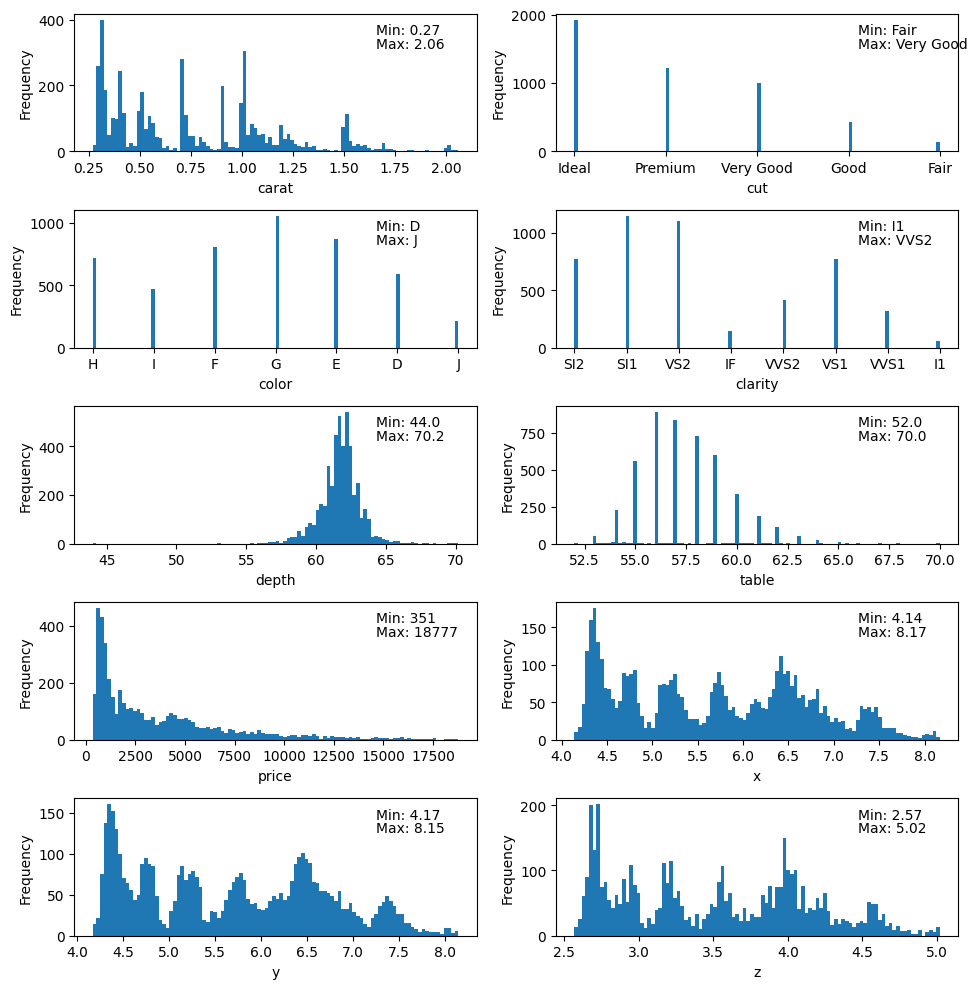

In [69]:
review_plot(df_cleaned)

### Encoding & Standarization

In [275]:
df_encoded = df_cleaned.copy()

In [276]:
#df_cleaned.info()
target = ['price']
numerical = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical = ['cut', 'color', 'clarity']

Encoding de categorical features:
- color: ordinal data -> label encoding (D-Z -> 1-20) (Supongo igual peso entre diferencial de color)
- cut & clarity: nominal data -> one hot encoding [0,1...]

In [277]:
color_mapping = {'D':1, 'E':2, 'F':3, 'G':4, 'H':5, 'I':6, 'J':7, 'K':8, 'L':9, 'M':10, 'N':11, 'O':12, 'P':13, 'Q':14, 'R':15, 'S':16, 'T':17, 'U':18, 'V':19, 'W':20, 'X':21, 'Y':22, 'Z':23}
df_encoded['color'] = df_encoded['color'].map(color_mapping)

In [278]:
for var in ['cut','clarity']:
    temp_df = pd.get_dummies(df_encoded[var], prefix=var, dtype=int)
    df_encoded = pd.concat([df_encoded, temp_df], axis=1)
    df_encoded.drop(var, axis=1,inplace=True)

In [279]:
scaler = StandardScaler() 
for var in (numerical):
    scaler.fit(df_encoded[[var]])
    df_encoded[var] = scaler.transform(df_encoded[[var]])

In [280]:
df_encoded.head()

,carat,color,depth,table,price,x,y,z,cut_Fair,cut_Good,...,cut_Premium,cut_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.830434,5,0.199386,-1.103550,4733,0.906951,0.948200,0.957161,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.300900,5,0.623136,-0.645737,6424,1.250801,1.224666,1.340140,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1.078048,6,-0.436239,0.269888,5510,1.172207,1.096307,1.068863,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1.820889,3,-0.577489,-0.645737,8770,1.712544,1.649240,1.579501,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.335207,3,-0.012489,-0.187924,4493,0.474681,0.513752,0.494396,0,0,...,0,1,0,0,0,0,0,1,0,0


<Axes: >

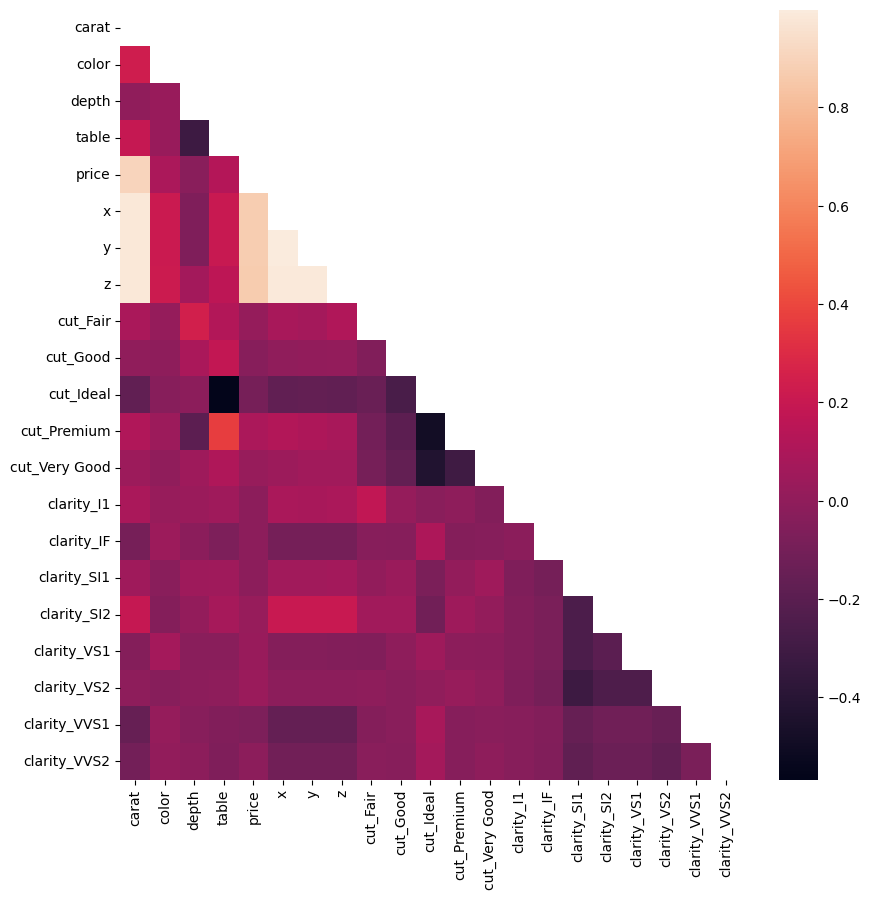

In [231]:
matrix_corr = df_encoded.corr() #matriz de correlación de los features
mask = np.zeros_like(matrix_corr)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix_corr,mask=mask,cmap="rocket")

* Se observa una alta correlación positiva entre las dimensiones de la gema y su peso (carat) con el precio.
* Las otras variables parecen ser poco determinantes (Una razón posible podría ser que tanto la forma como el color son características falsificables, no así la densidad y las características moleculares de las gemas)


## Modelo y training

In [281]:
df_final = df_encoded.copy()

#### Armo dataset 70-30(15-15) (train-validation-test)

In [282]:
train_feat, test_feat, train_target, test_target = train_test_split(df_final.drop('price', axis=1), df_final['price'], test_size=0.1, random_state=69)



In [ ]:
modelo = Pipeline([('features', PolynomialFeatures()),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
hyperparameters = {'features__degree': np.arange(1, 3)}
grilla = GridSearchCV(modelo, hyperparameters, refit=True, cv=len(train_feat), scoring='neg_mean_squared_error')
grilla.fit(train_feat, train_target)

In [132]:
print(grilla.best_params_)

{'features__degree': 2}


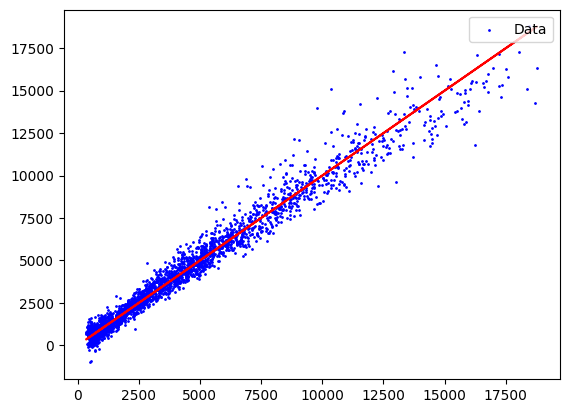

In [133]:
best_model = grilla.best_estimator_
plt.scatter(train_target, best_model.predict(train_feat), color='blue', label='Data', s=1)
plt.plot(train_target, train_target, color='red')
plt.legend(loc='upper right')
plt.show()

c:\Users\Pier\Documents\GitHub\xtream-ai-assignment-engineer\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.563e+08, tolerance: 5.128e+06
  model = cd_fast.enet_coordinate_descent(


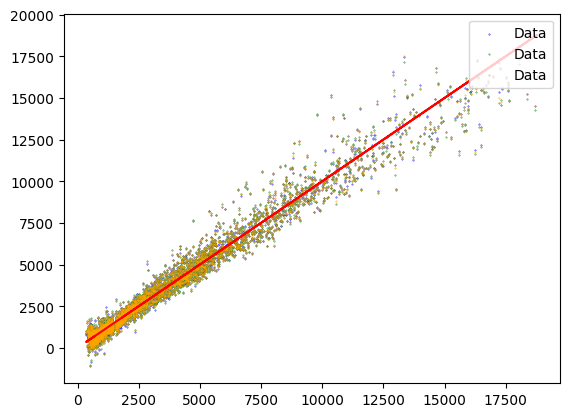

591.0854893644835 0.9710493360815889
597.8414429669533 0.9703837568602403
592.7954177101791 0.9708815932923618


In [291]:
poly = PolynomialFeatures(degree=2, include_bias=False)
train_poly = poly.fit_transform(train_feat)
reg_linear = LinearRegression()
reg_linear.fit(train_poly, train_target)
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(train_poly, train_target)
reg_ridge = Ridge(alpha=0.1)
reg_ridge.fit(train_poly, train_target)

plt.scatter(train_target, reg_linear.predict(train_poly), color='blue', label='Data', s=0.1)
plt.scatter(train_target, reg_lasso.predict(train_poly), color='green', label='Data', s=0.1)
plt.scatter(train_target, reg_ridge.predict(train_poly), color='orange', label='Data', s=0.1)
plt.plot(train_target, train_target, color='red')
plt.legend(loc='upper right')
plt.show()
print(math.sqrt(mse(train_target, reg_linear.predict(train_poly))), r2(train_target, reg_linear.predict(train_poly)))
print(math.sqrt(mse(train_target, reg_lasso.predict(train_poly))), r2(train_target, reg_lasso.predict(train_poly)))
print(math.sqrt(mse(train_target, reg_ridge.predict(train_poly))), r2(train_target, reg_ridge.predict(train_poly)))

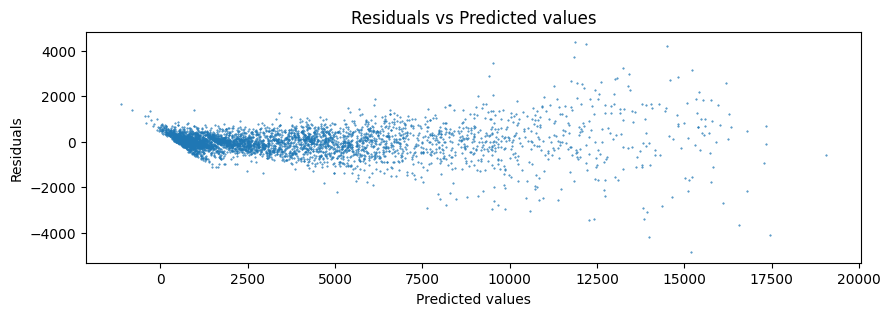

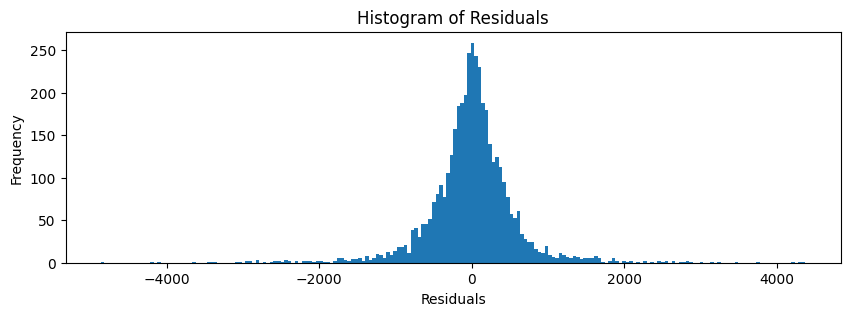

In [303]:
y_pred = reg_linear.predict(train_poly)
residuals = train_target - y_pred

plt.figure(figsize=(10,3))
plt.scatter(y_pred, residuals, s=0.2)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.figure(figsize=(10,3))
plt.hist(residuals, bins=200)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### final results

In [236]:
modelo = Pipeline([('features', PolynomialFeatures(degree=1)),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])

In [237]:
modelo.fit(train_feat, train_target)

Pipeline(steps=[('features', PolynomialFeatures(degree=1)),
                ('regression', LinearRegression(fit_intercept=False))])

In [243]:
df_final = df_cleaned.copy()
df_final["predicted_price"] = modelo.predict(df_encoded.drop('price', axis=1)).astype(int)

In [244]:
df_final[["price", "predicted_price"]]


,price,predicted_price
0,4733,4761
1,6424,7471
2,5510,6165
3,8770,10405
4,4493,4880
...,...,...
4995,832,1159
4996,927,997
4997,5980,7995
4998,802,536


In [248]:
df_final = df_cleaned.copy()
df_final.drop("cut", axis=1, inplace=True)
df_final.drop("color", axis=1, inplace=True)
df_final.drop("clarity", axis=1, inplace=True)
df_final.drop("table", axis=1, inplace=True)
df_final.drop("depth", axis=1, inplace=True)
df_final

,carat,price,x,y,z
0,1.10,4733,6.61,6.65,4.11
1,1.29,6424,6.96,6.93,4.35
2,1.20,5510,6.88,6.80,4.18
3,1.50,8770,7.43,7.36,4.50
4,0.90,4493,6.17,6.21,3.82
...,...,...,...,...,...
4995,0.38,832,4.65,4.69,2.91
4996,0.33,927,4.45,4.42,2.72
4997,1.25,5980,6.81,6.84,4.24
4998,0.31,802,4.31,4.27,2.70


In [259]:
modelo = Pipeline([('features', PolynomialFeatures(degree=1)),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])

In [261]:
train_feat, test_feat, train_target, test_target = train_test_split(df_final.drop('price', axis=1), df_final['price'], test_size=0.1, random_state=69)
modelo.fit(train_feat, train_target)
df_final["predicted_price"] = modelo.predict(df_final.drop('price', axis=1)).astype(int)
df_final[["price", "predicted_price"]]

,price,predicted_price
0,4733,6451
1,6424,7955
2,5510,6883
3,8770,10334
4,4493,4414
...,...,...
4995,832,850
4996,927,859
4997,5980,7441
4998,802,792


c:\Users\Pier\Documents\GitHub\xtream-ai-assignment-engineer\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e+09, tolerance: 5.128e+06
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pier\Documents\GitHub\xtream-ai-assignment-engineer\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.26872e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


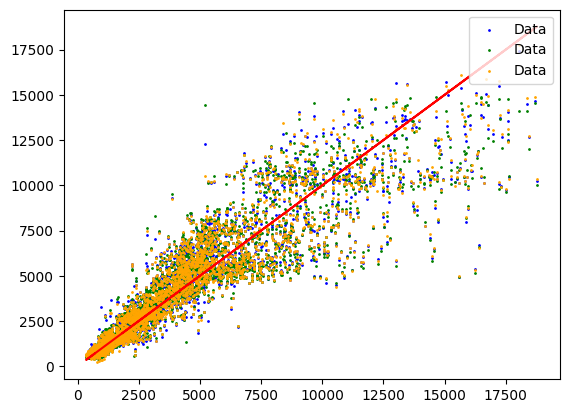

1776188.6950934278 0.8528205981877841
1816157.4782199466 0.8495086856595864
1741954.6668110131 0.8556573147022777


In [274]:
poly = PolynomialFeatures(degree=4, include_bias=False)
train_poly = poly.fit_transform(train_feat)
reg_linear = LinearRegression()
reg_linear.fit(train_poly, train_target)
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(train_poly, train_target)
reg_ridge = Ridge(alpha=0.2)
reg_ridge.fit(train_poly, train_target)

plt.scatter(train_target, reg_linear.predict(train_poly), color='blue', label='Data', s=1)
plt.scatter(train_target, reg_lasso.predict(train_poly), color='green', label='Data', s=1)
plt.scatter(train_target, reg_ridge.predict(train_poly), color='orange', label='Data', s=1)
plt.plot(train_target, train_target, color='red')
plt.legend(loc='upper right')
plt.show()
print(mse(train_target, reg_linear.predict(train_poly)), r2(train_target, reg_linear.predict(train_poly)))
print(mse(train_target, reg_lasso.predict(train_poly)), r2(train_target, reg_lasso.predict(train_poly)))
print(mse(train_target, reg_ridge.predict(train_poly)), r2(train_target, reg_ridge.predict(train_poly)))